In [1]:
import numpy as np
from mnist.loader import MNIST
import matplotlib.pyplot as plt
import glob
import os
import h5py
import librosa
import umap
import soundfile as sf

from tqdm import tqdm
from pathlib import Path
%matplotlib inline
import seaborn as sns
sns.set(style='white', context='poster')

batch_size=1000
sample_rate = 16000 #minimum 8000 for sf.write 
clip_length=5 #how many clips, not how many files r processed. btw

5 second clip splitter

In [2]:
def split(loaded_audio, file_name, clip_length = 2):
    chunk_samples = int(clip_length * sample_rate)
    chunks = [loaded_audio[i:i + chunk_samples] for i in range(0, len(loaded_audio), chunk_samples)]
    for i, chunk in enumerate(chunks): #thank u stack for this cool iterative
        output_file = f"fma_generated/{file_name}{i}.mp3"
        sf.write(output_file, chunk, sample_rate)
    
temp, _ = librosa.load('./fma_small/000/000002.mp3', sr=sample_rate)
temp = librosa.util.normalize(temp)
split(temp, '000002')

#total 8000 tracks
def load_batches(root_path, sample_rate, batch_size, clip_length = 5, output_dir='./fma_generated'):
    os.makedirs(output_dir, exist_ok=True)
    file_paths=[]
    for root, dirs, files in os.walk(root_path):
        for file in files:
            if file.endswith('.mp3'):
                file_paths.append(os.path.join(root, file))
                #print(file)
                
    np.random.seed(88)
    np.random.shuffle(file_paths)
    
    
    chunk_samples = int(clip_length * sample_rate) #actual number of samples per chunkclip
    
    
    file_index = 0
    batch_index = 0
    while file_index < len(file_paths):
        batch_clips=[]
        bathchs=[]
        while len(batch_clips)<batch_size and file_index < len(file_paths):
            file_path = file_paths[file_index]
            try:
                #print(f"processing {os.path.basename(file_path)}")
                
                audio, _ = librosa.load(file_path, sr=sample_rate)
                filename = os.path.splitext(os.path.basename(file_path))[0]
                
                clip_index = 0
                for i in range(0,len(audio), chunk_samples):
                    chunk = audio[i:i+chunk_samples]
                    
                    if len(chunk) == chunk_samples: #exactly 5 seconds
                        clip_filename = f"{filename}{clip_index:01d}.mp3" #single digit index :o
                        clip_path = os.path.join(output_dir, clip_filename)
                        
                        sf.write(clip_path, chunk, sample_rate)
                        batch_clips.append(chunk.copy()) #avoid ref issues
                        bathchs.append(clip_path)
                        clip_index += 1
                        
                        if len(batch_clips) >= batch_size:
                            break
            except Exception as e:
                #print(f"error loading {file_path}: {str(e)}")
                continue
            file_index+=1
        if len(batch_clips) > 0:
            print(f"batch {batch_index+1} with {len(batch_clips)} clips")
            
            yield batch_clips.copy(), bathchs.copy()
            del batch_clips, bathchs
            batch_index += 1
            
        else: break

In [3]:
def clear_generated(generated_dir='./fma_generated'):
    if os.path.exists(generated_dir):
        for file in tqdm(os.listdir(generated_dir)):
            if file.endswith('.mp3'):
                os.remove(os.path.join(generated_dir, file))
        os.rmdir(generated_dir)
        print(f"deleted absolutely everything within the following. directory. {generated_dir}")

In [4]:
clear_generated('./fma_generated')
big_data = load_batches('./fma_small', sample_rate, batch_size, clip_length) #generator function
batches=[]
pathches=[]


small_data, file_paths = next(big_data)
batches.append(small_data)
pathches.append(file_paths)

100%|██████████| 1016/1016 [00:00<00:00, 13764.39it/s]


deleted absolutely everything within the following. directory. ./fma_generated
batch 1 with 1000 clips


In [5]:
print(len(batches[0])) #first batch is 100 clips
print(len(batches[0][0])) #each clip is 30sec*5512 samples
print(batches[0][0]) #each sample 
print(np.mean(batches[0][0]))
print(np.std(batches[0][0]))

1000
80000
[-1.7075305e-10 -1.1975139e-09  1.4381516e-09 ...  2.1903120e-01
  2.0611468e-01  1.5005562e-01]
-7.7387097e-07
0.1252519


choose either standardization or normalization. normalize for models
https://en.wikipedia.org/wiki/Mel-frequency_cepstrum

In [6]:
import scipy
import sklearn.preprocessing
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

def into_mfccs_quick(audio, sample_rate):
    mfcc=librosa.feature.mfcc(y=audio, sr=sample_rate)
    #print(mfcc)
    if mfcc.max() == mfcc.min():
        return False
    return mfcc

def into_spectral_contrast(audio, sample_rate):
    spectral_contrast=librosa.feature.spectral_contrast(y=audio, sr=sample_rate)
    if spectral_contrast.max() == spectral_contrast.min():
        return False
    return normalize(spectral_contrast, axis=1)

def into_spectral_centroid(audio, sample_rate):
    return librosa.feature.spectral_centroid(y=audio, sr=sample_rate)

def into_melspecs(audio, sample_rate):
    mel_spec=librosa.feature.melspectrogram(y=audio, sr=sample_rate)
    #mel_db=librosa.power_to_db(mel_spec, ref=np.max) #scale to 1.0? perhaps??
    #librosa.display.specshow(mel_db, fmax=None, sr=sample_rate, x_axis='time', y_axis='mel')
    #plt.colorbar(format='%+2.0f dB')
    
    if mel_spec.max() == mel_spec.min():
        #i'm getting nans???
        return False
    
    #mel_normalized=2 * (mel_spec - mel_spec.min()) / (mel_spec.max() - mel_spec.min()) - 1
    flattened = mel_spec.flatten()
    #mel_standardized = (mel_db - np.mean(mel_db)) / np.std(mel_db)
    #flattened = mel_standardized.flatten()
    return flattened

def into_textures(mel_spec, power = 2.0): #mel-frequency cepstrum. timbre
    if mel_spec is False or mel_spec is None:
        return False
    try: 
        logged = np.log(mel_spec + np.full_like(mel_spec, 1e-5))
        dct_powered = scipy.fft.dct(np.power(logged, power))
        normalized_textures = (dct_powered - np.mean(dct_powered)) / (np.std(dct_powered))
        return normalized_textures
    except Exception as e:
        print(f"{e}")
        return False

def into_freqs(audio, sample_rate):
    output, _, probabilities = librosa.pyin(audio, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'), sr=sample_rate, pad_mode='constant', n_thresholds = 10)
    output = np.nan_to_num(output, -1)
    #512 step
    return output, probabilities

def fourier_tempogram(audio, sample_rate):
    return librosa.feature.fourier_tempogram(y=audio, sr=sample_rate, win_length=128)

def tonal_centroid(audio, sample_rate):
    return librosa.feature.tonnetz(y=audio, sr=sample_rate)

test, testprob = into_freqs(batches[0][3], sample_rate)
test2 = into_textures(into_melspecs(batches[0][0], sample_rate))
test3 = into_mfccs_quick(batches[0][3], sample_rate)
test4 = tonal_centroid(batches[0][3], sample_rate)
# print(f"{test2.shape}\n{test}")
# print(f"{test3.shape}\n{test}")
print(f"{test4.shape}\n{test}")

(6, 157)
[83.84733628 83.84733628 83.84733628 84.33305896 83.84733628  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.

filtering out that one clip that's not the right length

In [7]:
%%time
batches_mels=[]
centroids=[]
pathches_mels=[]
freqs=[]
probs=[]
tempos=[]
tones=[]

temp=[]
tempfreqs=[]
tempprobs=[]
tempmpograms=[]
temptones=[]
temproids=[]
print(f'initial lengths:\n batches[0]: {len(batches[0])} \n pathches[0]: {len(pathches[0])}')
for i, clip in enumerate(tqdm(batches[0], desc='into freqs processing')):
   target_length = 1 + int(np.floor((clip_length * sample_rate)/512)) + 1 # 512 is default hop
   
   #mel_specs = into_melspecs(clip, sample_rate)
   harmonic, percussive = librosa.effects.hpss(clip, margin=8)
   mel_texture = into_mfccs_quick(clip, sample_rate)
   #spectral_centroid = into_spectral_centroid(clip, sample_rate)
   #mel_texture = into_mfccs_quick(clip, sample_rate)
   fourier_temp = fourier_tempogram(clip, sample_rate) #perhaps only percussive?
   tonnetz = tonal_centroid(harmonic, sample_rate)
   
   #mel_harmonics, probabilities = into_freqs(clip, sample_rate)
   if mel_texture is False:
      print(f'failure at {i} spectrogram')
      continue
      # temp.append(False)
      # tempfreqs.append(False)
      # #tempprobs.append(False)
      # tempmpograms.append(False)
      # temproids.append(False)
      # temptones.append(False)
      # continue
   # mel_texture = into_textures(mel_specs)
   # if mel_texture is False:
   #    print(f'failure at {i} texture')
   #    temp.append(False)
   #    tempfreqs.append(False)
   #    tempprobs.append(False)
   #    continue
   mel_texture = librosa.util.fix_length(mel_texture, size = target_length, axis=1)
   #spectral_centroid = librosa.util.fix_length(spectral_centroid, size = target_length, axis=1)
   tonnetz = librosa.util.fix_length(tonnetz, size = target_length, axis=1)
   
   temp.append(mel_texture) 
   #temproids.append(spectral_centroid)
   #tempfreqs.append(mel_harmonics) #replaced freqs with tones
   #tempprobs.append(probabilities)
   tempmpograms.append(fourier_temp)
   temptones.append(tonnetz)
   
   
   
   
batches_mels.append(temp)
centroids.append(temproids)
#freqs.append(tempfreqs)
tempos.append(tempmpograms)
tones.append(temptones)
#probs.append(tempprobs)
pathches_mels.append(pathches[0])

lengths = [len(i) for i in batches_mels[0] if i is not False]
most_common_length = max(set(lengths), key=lengths.count)
filtered_paths = [path for mel, path in zip(batches_mels[0], pathches[0]) if mel is not False and len(mel) == most_common_length]
#filtered_freqs = [freq for mel, freq in zip(batches_mels[0], freqs[0]) if mel is not False and len(mel) == most_common_length]
filtered_tempos = [tempo for mel, tempo in zip(batches_mels[0], tempos[0]) if mel is not False and len(mel) == most_common_length]
filtered_tones = [tone for mel, tone in zip(batches_mels[0], tones[0]) if mel is not False and len(mel) == most_common_length]
#filtered_centroids = [centroid for mel, centroid in zip(batches_mels[0], centroids[0]) if mel is not False and len(mel) == most_common_length]
#filtered_probs = [prob for mel, prob in zip(batches_mels[0], probs[0]) if mel is not False and len(mel) == most_common_length]
filtered_mels = [mel for mel in batches_mels[0] if mel is not False and len(mel) == most_common_length]

print(f"\nsummary!")
print(f"initial total: {len(batches[0])}")
print(f"filtered mels count: {len(filtered_mels)}")
print(f"filtered paths count: {len(filtered_paths)}")

batches_mels[0] = np.array(filtered_mels, dtype=np.float32)
#centroids[0] = np.array(filtered_centroids, dtype=np.float32)
#freqs[0] = filtered_freqs
tempos[0] = np.array(filtered_tempos, dtype=np.float32)
tones[0] = np.array(filtered_tones, dtype=np.float32)
#probs[0] = filtered_probs
pathches_mels[0] = filtered_paths
tempos[0]= np.array(tempos[0])
tones[0] = np.array(tones[0])

#flatten everything:
batches_mels[0] = batches_mels[0].reshape(batches_mels[0].shape[0], -1)  
#centroids[0] = centroids[0].reshape(centroids[0].shape[0], -1)  
tempos[0] = tempos[0].reshape(tempos[0].shape[0], -1) 
tones[0] = tones[0].reshape(tones[0].shape[0], -1) 


initial lengths:
 batches[0]: 1000 
 pathches[0]: 1000


into freqs processing:  30%|███       | 302/1000 [00:51<01:52,  6.20it/s]/Users/user/Desktop/coding comps/transition/venv/lib/python3.13/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
into freqs processing: 100%|██████████| 1000/1000 [02:52<00:00,  5.81it/s]
<timed exec>:85: ComplexWarning: Casting complex values to real discards the imaginary part



summary!
initial total: 1000
filtered mels count: 1000
filtered paths count: 1000
CPU times: user 2min 44s, sys: 1.68 s, total: 2min 45s
Wall time: 2min 52s


normalization

In [11]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# ---------- helper ---------------------------------------------------------
def whiten_and_weight(block, d_ref):
    #standardization
    block = StandardScaler().fit_transform(block)

    #dim scaling
    d_block = block.shape[1]
    weight  = np.sqrt(d_ref / d_block) 
    return block * weight
# --------------------------------------------------------------------------

# choose the smallest block's dimension as reference
d_ref = tones[0].shape[1]     # 948

# apply to every block
mfccs_scaled = whiten_and_weight(batches_mels[0], d_ref) #spectral contrast is also dogshit. but mfccs did somewhat do something
tempograms_scaled = whiten_and_weight(np.real(tempos[0]), d_ref)  #works but it has a poorly motivated purpose
tonnetzs_scaled = whiten_and_weight(tones[0],         d_ref)    #decent
#centroids_scaled = whiten_and_weight(centroids[0], d_ref) #dogshit

combined = np.hstack([mfccs_scaled, tempograms_scaled, tonnetzs_scaled])

no custom metrics! no need for them :)

In [ ]:
%%time
#not using metric
unsup_embedding = umap.UMAP(n_neighbors=30, n_components = 20).fit_transform(combined)

/Users/user/Desktop/coding comps/transition/venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CPU times: user 4.62 s, sys: 270 ms, total: 4.89 s
Wall time: 3.07 s


thank you gpt. i would never read all this documentation

In [14]:
import dash
from dash import dcc, html, Input, Output
import plotly.express as px
import pandas as pd
import os
import flask
import librosa
import numpy as np

# After your UMAP processing and filtering...
# Create DataFrame from your clip data
def create_clip_dataframe(umap_embedding, pathches_mels):
    """
    Create DataFrame for clips instead of full audio files
    """
    df = pd.DataFrame({
        'UMAP1': umap_embedding[:, 0],
        'UMAP2': umap_embedding[:, 1], 
        'Clip_Path': pathches_mels,
        'Original_File': [extract_original_filename(path) for path in pathches_mels],
        'Clip_Index': [extract_clip_index(path) for path in pathches_mels]
    })
    
    # Create audio URLs for serving
    df['audio_url'] = df['Clip_Path'].apply(get_clip_audio_url)
    
    return df

def extract_original_filename(clip_path):
    """Extract original filename from clip path"""
    # ./fma_generated/000002_clip_000.mp3 -> 000002
    basename = os.path.basename(clip_path)
    # Remove extension and clip suffix
    name_without_ext = os.path.splitext(basename)[0]
    # Split on '_clip_' and take first part
    if '_clip_' in name_without_ext:
        return name_without_ext.split('_clip_')[0]
    return name_without_ext

def extract_clip_index(clip_path):
    """Extract clip index from clip path"""
    # ./fma_generated/000002_clip_000.mp3 -> 0
    basename = os.path.basename(clip_path)
    name_without_ext = os.path.splitext(basename)[0]
    if '_clip_' in name_without_ext:
        try:
            return int(name_without_ext.split('_clip_')[1])
        except (ValueError, IndexError):
            return 0
    return 0

def get_clip_audio_url(clip_path):
    """Convert clip path to URL for serving"""
    # ./fma_generated/000002_clip_000.mp3 -> /audio/000002_clip_000.mp3
    filename = os.path.basename(clip_path)
    return f'/audio/{filename}'

# Create your DataFrame
df = create_clip_dataframe(unsup_embedding, pathches_mels[0])

# Initialize Dash app
app = dash.Dash(__name__)

# Set up audio serving directory (your generated clips)
AUDIO_DIR = os.path.abspath('fma_generated')  # Changed from 'fma_small' to 'fma_generated'

@app.server.route('/audio/<path:filename>')
def serve_audio(filename):
    """Serve audio clips from fma_generated directory"""
    if '..' in filename or filename.startswith('/'):
        flask.abort(404)
    return flask.send_from_directory(AUDIO_DIR, filename)

# Create the scatter plot
fig = px.scatter(
    df, 
    x="UMAP1", 
    y="UMAP2", 
    hover_data=["Original_File", "Clip_Index"], 
    custom_data=['audio_url'],
    title="UMAP",
    labels={'UMAP1': 'Arbitrary Dimension 1', 'UMAP2': 'Arbitrary Dimension 2'}
)

fig.update_layout(
    autosize=True,
    height=600  # Set minimum height
)

# Update hover template to show clip info
fig.update_traces(
    hovertemplate="<b>Original File:</b> %{customdata[1]}<br>" +
                  "<b>Clip Index:</b> %{customdata[2]}<br>" +
                  "<b>UMAP1:</b> %{x}<br>" +
                  "<b>UMAP2:</b> %{y}<extra></extra>"
)

app.layout = html.Div([
    #html.H1("analysis", style={'textAlign': 'center'}),
    #html.P(f"this many!!! {len(df)} audio clips", style={'textAlign': 'center'}),
    dcc.Graph(id="scatter", figure=fig),
    html.Div([
        html.Audio(id='audio-player', controls=True, src=''),
        html.Div(id='clip-info', style={'marginTop': '10px'})
    ], style={'margin': '20px'})
])

@app.callback(
    [Output('audio-player', 'src'),
     Output('clip-info', 'children')],
    Input('scatter', 'clickData')
)
def update_audio(clickData):
    if clickData and "points" in clickData:
        audio_url = clickData["points"][0]["customdata"][0]
        
        # Get point index to show clip info
        point_idx = clickData["points"][0]["pointIndex"]
        clip_info = html.Div([
            html.P(f"file path: {df.iloc[point_idx]['Original_File']}{df.iloc[point_idx]['Clip_Index']:01d}.mp3"),
            html.P(f"({df.iloc[point_idx]['UMAP1']:.3f}, {df.iloc[point_idx]['UMAP2']:.3f})")
        ])
        
        return audio_url, clip_info
    
    return '', html.P("")

if __name__ == "__main__":
    print(f"Serving {len(df)} audio clips")
    print(f"Audio files served from: {AUDIO_DIR}")
    app.run(debug=True) 

Serving 1000 audio clips
Audio files served from: /Users/user/Desktop/coding comps/transition/fma_generated


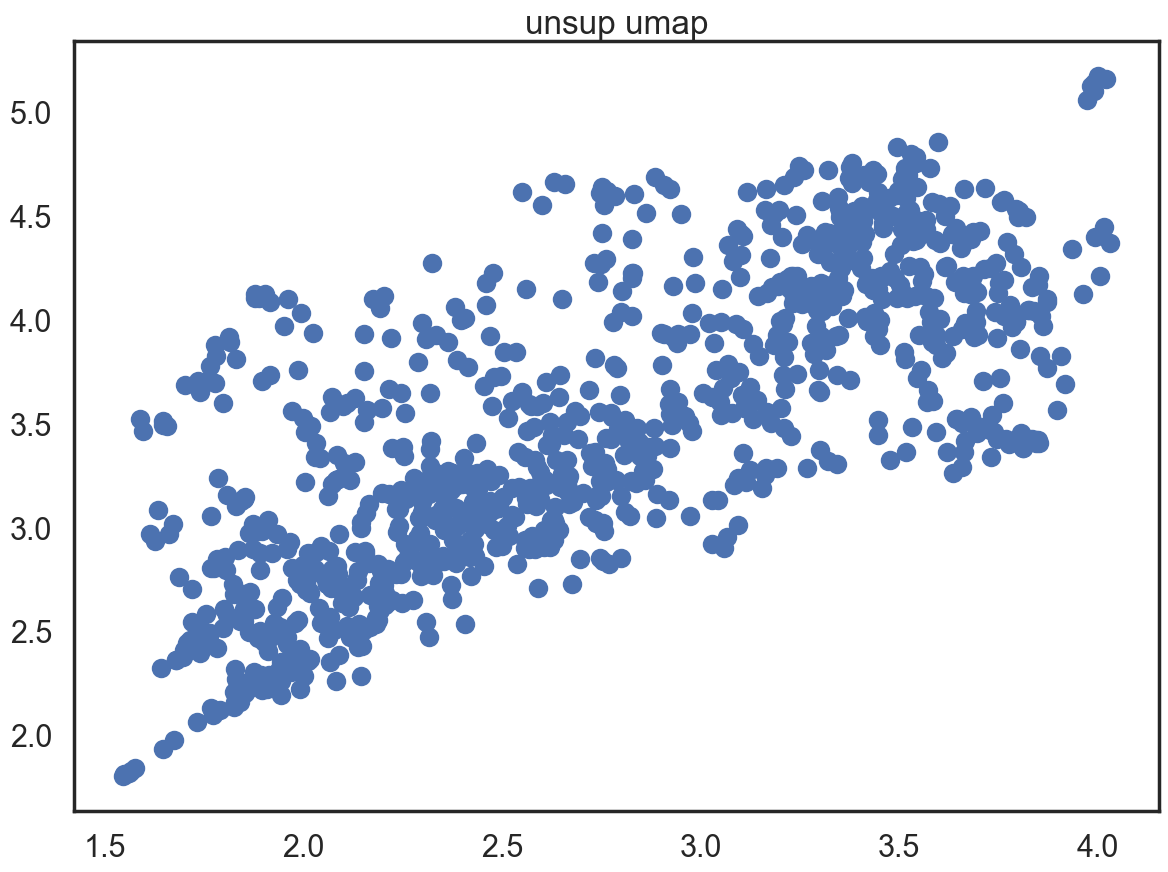

In [13]:
plt.figure(figsize=(14, 10))
plt.scatter(unsup_embedding[:, 0], unsup_embedding[:, 1])
plt.title('unsup umap')
plt.show()

okay so integer linear programming is totally unfeasible since solvers still explore something on the scale of literally every path. thus i shall use heuristic stuff. wait though. if i have a metric i believe in this is this basically slightly obfuscated direct programming? no. because umap guarantees distances satisfy triangle inequality. not sure if my metirc was originally triangleproof tho

okay so basically i'm going to implement christofides

in conclusion christofides' sucks ASS!!!!?????

In [15]:

def path_sounds_like(walk_path_thing, output_directory="./fma_generated"):
    combined_audio=[]
    for index, location in enumerate(walk_path_thing):
        file_path = pathches_mels[0][location]
        audio, _ = librosa.load(file_path, sr=sample_rate)
        combined_audio=np.concatenate([combined_audio,audio])
        if index>200:
            break
    print(np.shape(combined_audio))
    clip_name = f"00000000combined.mp3"
    clip_path = os.path.join(output_directory, clip_name)
    sf.write(clip_path, combined_audio, sample_rate)

#path_sounds_like(walk_path_thing=walk)

In [16]:
%%time
import elkai


fixed_len = len(batches_mels[0])
elkaidists=np.zeros((fixed_len, fixed_len), dtype=int)
dists=[]
dist_ids=[]
for i in tqdm(range(fixed_len)):
    for j in range(i+1, fixed_len):
        edist=int(round(np.linalg.norm(unsup_embedding[i]-unsup_embedding[j]) * 1000))
        dists.append(edist)
        elkaidists[i, j]=edist
        elkaidists[j, i]=edist


import numpy as np

print("Shape:", elkaidists.shape)
print("Dtype:", elkaidists.dtype)
print("Symmetric:", np.allclose(elkaidists, elkaidists.T))
print("Diagonal 0s:", np.all(np.diag(elkaidists) == 0))
print("Any NaNs:", np.any(np.isnan(elkaidists)))
print("Max distance:", np.max(elkaidists))
print("Min (nonzero) distance:", np.min(elkaidists[np.nonzero(elkaidists)]))

100%|██████████| 1000/1000 [00:01<00:00, 527.75it/s]

Shape: (1000, 1000)
Dtype: int64
Symmetric: True
Diagonal 0s: True
Any NaNs: False
Max distance: 4024
Min (nonzero) distance: 24
CPU times: user 1.63 s, sys: 631 ms, total: 2.27 s
Wall time: 1.95 s


In [17]:
walk = elkai.solve_int_matrix(elkaidists.tolist())
path_sounds_like(walk_path_thing=walk)
print(walk)

(16160000,)
[0, 260, 736, 739, 281, 565, 568, 255, 258, 874, 896, 876, 88, 869, 91, 146, 204, 282, 202, 617, 62, 731, 894, 743, 92, 89, 531, 667, 207, 419, 890, 719, 546, 543, 545, 547, 421, 418, 463, 36, 33, 34, 435, 697, 478, 436, 745, 37, 298, 986, 488, 487, 486, 484, 485, 513, 586, 585, 628, 399, 402, 400, 403, 404, 401, 797, 717, 373, 374, 856, 855, 335, 407, 800, 674, 511, 134, 336, 338, 337, 334, 650, 835, 838, 839, 836, 927, 834, 708, 502, 97, 94, 98, 95, 837, 387, 680, 683, 223, 226, 519, 817, 814, 815, 812, 816, 813, 225, 642, 386, 938, 71, 70, 69, 68, 66, 67, 962, 959, 434, 264, 262, 347, 677, 941, 939, 942, 964, 940, 943, 961, 963, 904, 902, 901, 905, 903, 410, 786, 704, 705, 707, 703, 706, 702, 935, 409, 489, 584, 833, 583, 213, 405, 625, 214, 582, 673, 877, 944, 678, 537, 61, 363, 848, 274, 277, 695, 432, 635, 630, 633, 473, 474, 476, 475, 477, 693, 631, 534, 533, 692, 9, 470, 10, 469, 540, 467, 472, 471, 632, 501, 503, 499, 427, 431, 429, 78, 634, 428, 430, 670, 2, 741, 

path verification

In [18]:
import plotly.graph_objects as go
import plotly.express as px

# ------------------------------------------------------------
# 1.  Build a DataFrame (already done)
df = create_clip_dataframe(unsup_embedding, pathches_mels[0])

# ------------------------------------------------------------
# 2.  Your existing scatter
fig = px.scatter(
    df,
    x="UMAP1",
    y="UMAP2",
    hover_data=["Original_File", "Clip_Index"],
    custom_data=["audio_url"],
    title="UMAP",
    labels={"UMAP1": "Arbitrary Dimension 1",
            "UMAP2": "Arbitrary Dimension 2"}
)

# ------------------------------------------------------------
# 3.  Add a path trace
#    `walk` is an ordered list/array of indices into df/embedding
xs = df.loc[walk, "UMAP1"]
ys = df.loc[walk, "UMAP2"]

fig.add_trace(
    go.Scatter(
        x=xs,
        y=ys,
        mode="lines+markers",
        line=dict(color="red", width=2),
        marker=dict(size=6, symbol="circle"),
        name="Path"
    )
)

fig.update_layout(
    autosize=True,
    height=600
)

# ------------------------------------------------------------
# 4.  Dash layout stays the same
app.layout = html.Div([
    dcc.Graph(id="scatter", figure=fig),
    html.Div([
        html.Audio(id="audio-player", controls=True, src=""),
        html.Div(id="clip-info", style={"marginTop": "10px"})
    ], style={"margin": "20px"})
])
